In [144]:
import numpy as np
import matplotlib.pyplot as plt

import functions as mp
import importlib
importlib.reload(mp) # reloads package after changes have been made

<module 'functions' from '/Users/quanle/feature_interactions/functions.py'>

In [154]:
M = 20 
N = 200
K = 5
J1 = 0 
J2 = 1

SNR = np.linspace(0, 10, 20)

n_ratio = np.sqrt(N) / N
m_ratio = np.sqrt(M) / M

B = 1000
num_trials = 100

model = mp.DecisionTreeReg

In [156]:

mp_params = [M, N, K, n_ratio, m_ratio, B, model, J1, J2]

plt_power = [0] * len(SNR)
errors = [0] * len(SNR)

from joblib import Parallel, delayed
def f(M, N, K, n_ratio, m_ratio, B, model, J1, J2, snr): 
    X, Y = mp.kSparseLinearModel(N, M, K)
    Y += snr * (X[:,J1] * X[:,J2])
    Y = (Y - np.mean(Y)) / np.std(Y)
    delta_cap, ci = mp.featureInteractions(X, Y, n_ratio, m_ratio, B, model, None, 
                                            J1, J2, alpha=0.1)
    return 1 if (delta_cap + ci < 0) or (delta_cap - ci > 0) else 0
        
        
for i, snr in enumerate(SNR):
    power = Parallel(n_jobs=-1)(delayed(f)(*mp_params, snr) for i in range(num_trials))
        
    errors[i] = np.std(power)
    plt_power[i] = np.mean(power)





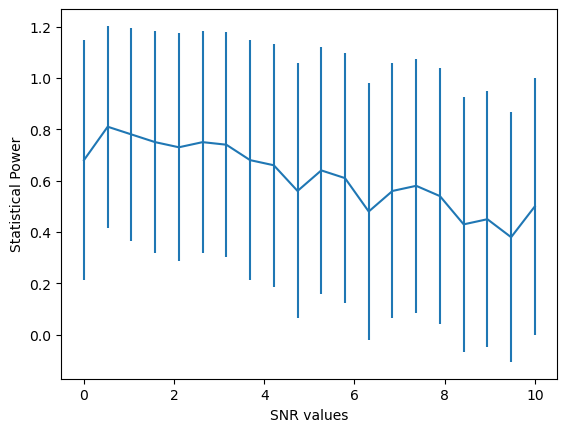

In [157]:
plt.errorbar(SNR, plt_power, yerr = errors)
plt.xlabel("SNR values")
plt.ylabel("Statistical Power")
plt.show()


/var/folders/q3/_ggffzj933s64pz_z4jk4ds80000gn/T/ipykernel_37941/1285220792.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  plt.scatter(X1 @ np.linalg.lstsq(X1, Y)[0], Y)


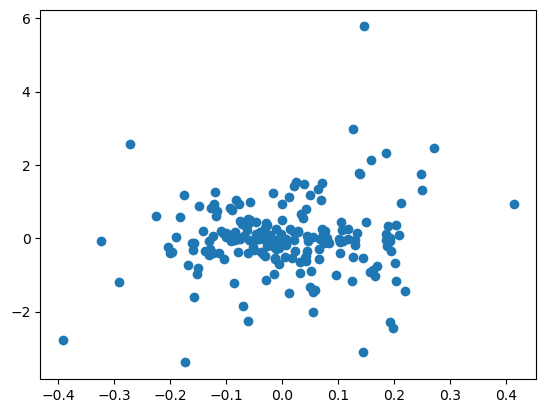

1.0114820291440925
1.0150368818546245
1.0103531668508905
1.0120850330586633


(-0.0018229865027596364, 0.0019762695956335565)

In [155]:
# single instance verification
snr = 100
X, Y = mp.kSparseLinearModel(N, M, K)
Y += snr * (X[:,J1] * X[:,J2])
Y = (Y - np.mean(Y)) / np.std(Y)
X1 = X[:, [1,2,3,4]]
plt.scatter(X1 @ np.linalg.lstsq(X1, Y)[0], Y)
plt.show()

predictions, mp_observations, mp_features = mp.predict(X, Y, n_ratio, m_ratio, B, model, None)
r = mp.computeDeltaCap(Y, J1, J2, predictions, mp_observations, mp_features)
for v in r:
    print(v.mean())

dc = r[0] - r[1] - r[2] + r[3]
# dc = r[0] - r[3]
ci = mp.getCI(dc, alpha=0.1)
np.mean(dc), ci
